In [1]:
import sys
sys.path.append("../functions")
import pickle
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import scipy.stats as stats
from utils import *
import scipy.io as sio
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 20
matplotlib.rcParams['axes.edgecolor'] = 'black'

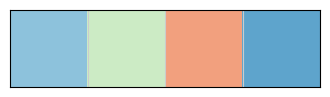

In [2]:
# sns_colors = [sns.color_palette(palette='Pastel1')[2], sns.color_palette(palette='Pastel1')[1], sns.color_palette(palette='Pastel1')[0]]
sns_colors = [sns.color_palette("RdBu", 16)[11],  sns.color_palette(palette='Pastel1')[2], sns.color_palette("RdBu",16)[4], sns.color_palette("RdBu",16)[12]]
dark_colors = [sns.desaturate(color, 0.7) for color in sns_colors]
sns.palplot(sns_colors)


#### Read the data, predicted result, and mask

In [4]:
dataset_type = 'HCPA' # select the dataset: HCPA, HCPD, ABCD
SC_mask_type = 75 #  select the mask type: 25, 75


with open(
        '../data/info/SC_mask_' +str(SC_mask_type) + '.pickle',
        'rb') as out_data:
    (HCPA_sc_mask, HCPD_sc_mask, ABCD_sc_mask) = pickle.load(out_data)

if dataset_type == 'HCPA':
    try:
        with open('../data/preprocessed_data/HCPA_SC_FC_reSC_info_245.pickle',
                  'rb') as out_data:
            (SC, FC, SC_re, info) = pickle.load(out_data)
    except Exception:
        # pandas package may report error for >2.0 version
        (SC, FC, SC_re, info) = pd.read_pickle('../data/preprocessed_data/HCPA_SC_FC_reSC_info_245.pickle')

    with open('../data/result_out/HCPA/GCN_dim128lr0.001b2ep400reg0.0001prelu.pickle', 'rb') as out_data:
        predFC_train, predFC_test = pickle.load(out_data)
    with open('../data/result_out/HCPA/rewired_GCN_dim128lr0.001b2ep400reg0.0001prelu.pickle', 'rb') as out_data:
        predFC_train_re, predFC_test_re, predFC_test_re_rewTest = pickle.load(out_data)
    SC_mask = HCPA_sc_mask

elif dataset_type == 'HCPD':
    try:
        with open('../data/preprocessed_data/HCPD_SC_FC_reSC_info_410.pickle',
                  'rb') as out_data:
            (SC, FC, SC_re, info) = pickle.load(out_data)
    except:
        (SC, FC, SC_re, info) = pd.read_pickle('../data/preprocessed_data/HCPD_SC_FC_reSC_info_410.pickle')

    with open('../data/result_out/HCPD/GCN_dim128lr0.001b2ep400reg0.0001prelu.pickle', 'rb') as out_data:
        predFC_train, predFC_test = pickle.load(out_data)
    with open('../data/result_out/HCPD/rewired_GCN_dim128lr0.001b2ep400reg0.0001prelu.pickle', 'rb') as out_data:
        predFC_train_re, predFC_test_re, predFC_test_re_rewTest = pickle.load(out_data)
    SC_mask = HCPD_sc_mask


else:
    with open('../data/preprocessed_data/ABCD_SC_FC_reSC_info_1572_4run.pickle', 'rb') as out_data:
            (SC, FC, SC_re, info) = pickle.load(out_data)
    with open('../data/result_out/ABCD/GCN_dim128lr0.001b2ep400reg0.0001prelu.pickle', 'rb') as out_data:
        predFC_train, predFC_test = pickle.load(out_data)
    with open('../data/result_out/ABCD/rewired_GCN_dim128lr0.001b2ep400reg0.0001prelu.pickle', 'rb') as out_data:
        predFC_train_re, predFC_test_re, predFC_test_re_rewTest = pickle.load(out_data)
    SC_mask = ABCD_sc_mask

SC_train, SC_test, FC_train, FC_test, SC_train_re, SC_test_re, = train_test_split(SC, FC,SC_re, test_size=0.5,  random_state=0)


SC_mask_flatten = flatten_symmetric_matrix(SC_mask)
SC_mask_flatten_index = np.where(SC_mask_flatten==1)[0]
SC_mask_flatten_index_zero = np.where(SC_mask_flatten==0)[0]

#### Group average plot

In [5]:
mean_SC_flatten = flatten_symmetric_matrix(np.mean(SC, axis=0))
mean_FC_flatten = flatten_symmetric_matrix(np.mean(np.tanh(FC), axis=0))
mean_FC_flatten_test = flatten_symmetric_matrix(np.mean(np.tanh(FC_test), axis=0))
mean_predFC_flatten = flatten_symmetric_matrix(np.mean(np.tanh(predFC_test), axis=0))
mean_predFC_re_flatten = flatten_symmetric_matrix(np.mean(np.tanh(predFC_test_re), axis=0))
mean_SC_flatten_masked = mean_SC_flatten[SC_mask_flatten_index]
mean_FC_flatten_masked = mean_FC_flatten[SC_mask_flatten_index]

r_mean_sc = stats.pearsonr(np.log(mean_SC_flatten_masked), mean_FC_flatten_masked)[0]
r_mean_predFC = stats.pearsonr(mean_predFC_flatten, mean_FC_flatten_test)[0]
r_mean_predFC_re = stats.pearsonr(mean_predFC_re_flatten, mean_FC_flatten_test)[0]

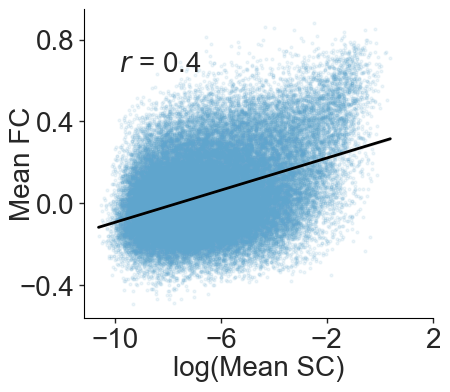

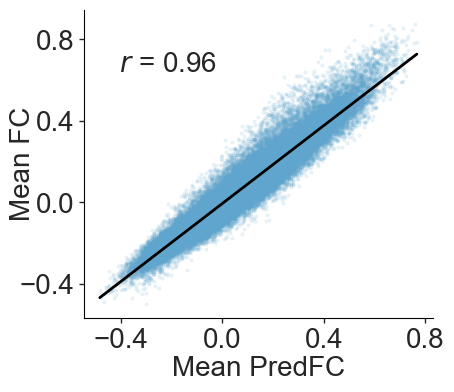

In [8]:
scatter = pd.DataFrame({'log(Mean SC)': np.log(mean_SC_flatten_masked), 'Mean FC': mean_FC_flatten_masked})
# sns.set(font_scale = 1)

_, ax = plt.subplots(figsize=(4.5, 4))
g = sns.regplot(x='log(Mean SC)', y='Mean FC', data=scatter, scatter_kws={"alpha": 0.1, 's':4, 'color':sns_colors[3]}, marker='o', line_kws={"color": 'black', 'linewidth': 2})
plt.annotate(r'$r$'+ ' = ' + str(round(r_mean_sc,2)),xy=(0.1,0.8), fontsize=20,xycoords='axes fraction')
ax.set_xticks(np.arange(-10, 4.1, 4))
ax.set_yticks(np.arange(-0.4, 0.8, 0.4))
sns.despine()
ax.tick_params(bottom=True, left=True, width=1)
ax.set_ylabel('Mean FC', labelpad=-12,fontsize=20)
ax.set_xlabel('log(Mean SC)', labelpad=2,fontsize=20)
name = "../result_plot/Fig2/" + dataset_type  + "_mean_sc_fc_scatter" + ".png"
# # plt.gcf().set_size_inches(4.5, 4)
plt.grid(False)
plt.savefig(name,bbox_inches = 'tight', dpi=360,transparent=True)
plt.show()

scatter = pd.DataFrame({'Mean PredFC': mean_predFC_flatten, 'Mean FC': mean_FC_flatten_test})
_, ax = plt.subplots(figsize=(4.5, 4))
sns.regplot(x='Mean PredFC', y='Mean FC', data=scatter, scatter_kws={"alpha": 0.1, 's':4, 'color':sns_colors[3]}, marker='o', line_kws={"color": 'black', 'linewidth': 2})
plt.annotate(r'$r$'+ ' = ' + str(round(r_mean_predFC,2)),xy=(0.1,0.8), fontsize=20,xycoords='axes fraction')
ax.tick_params(bottom=True, left=True, width=1)

# plt.tight_layout()
plt.xticks(np.arange(-0.4, 0.8, 0.4))
plt.yticks(np.arange(-0.4, 0.8, 0.4))
plt.grid(False)
sns.despine()
plt.ylabel('Mean FC', labelpad=-12,fontsize=20)
plt.xlabel('Mean PredFC', labelpad=2,fontsize=20)
name = "../result_plot/Fig2/" + dataset_type + "_mean_predfc_fc_scatter" + ".png"
plt.savefig(name,bbox_inches = 'tight', dpi=360,transparent=True)
plt.show()

#### Individual plot

In [9]:
corr_SC_FC = []
corr_SC_FC_re = []
corr_predFC_FC = []
corr_predFC_FC_re = []

for i in range(FC_test.shape[0]):
    FC_flatten = flatten_symmetric_matrix(FC_test[i, :, :])
    corr_predFC_FC.append(np.corrcoef(FC_flatten, flatten_symmetric_matrix(predFC_test[i, :, :]))[0, 1])
    corr_predFC_FC_re.append(np.corrcoef(FC_flatten, flatten_symmetric_matrix(predFC_test_re[i, :, :]))[0, 1])

for i in range(FC.shape[0]):
    SC_flatten = flatten_symmetric_matrix(SC[i, :, :])[SC_mask_flatten_index]
    nozero_index = np.where(SC_flatten>0)[0]
    SC_flatten = np.log(SC_flatten[nozero_index])
    FC_flatten = flatten_symmetric_matrix(FC[i, :, :])[SC_mask_flatten_index][nozero_index]
    corr_SC_FC.append(np.corrcoef(SC_flatten, FC_flatten)[0, 1])
    SC_re_flatten = flatten_symmetric_matrix(SC_re[i, :, :])
    nozero_index = np.where(SC_re_flatten>0)[0]
    SC_re_flatten = np.log(SC_re_flatten[nozero_index])
    FC_flatten = flatten_symmetric_matrix(FC[i, :, :])[nozero_index]
    corr_SC_FC_re.append(np.corrcoef(FC_flatten, SC_re_flatten)[0, 1])

corr_SC_FC = np.array(corr_SC_FC)
corr_SC_FC_re = np.array(corr_SC_FC_re)
corr_predFC_FC = np.array(corr_predFC_FC)
corr_predFC_FC_re = np.array(corr_predFC_FC_re)

mean_r_SC = np.mean(corr_SC_FC)
mean_r_predFC = np.mean(corr_predFC_FC)
mean_r_SC_re = np.mean(corr_SC_FC_re)
mean_r_predFC_re = np.mean(corr_predFC_FC_re)

In [10]:
print("mean: ", np.mean(corr_predFC_FC), "std: ", np.std(corr_predFC_FC))
print("mean: ", np.mean(corr_predFC_FC_re), "std: ", np.std(corr_predFC_FC_re))

mean:  0.7143283636007709 std:  0.05150583214142987
mean:  0.2588581301239361 std:  0.04286732590433821


/var/folders/9s/wnnzhx9x70101x6g_jm5k8dc0000gn/T/ipykernel_66795/2611194966.py:43: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.stripplot(x="Type", y="Correlation", data=df_ind_corr, hue="Mode", palette=sns_colors, dodge=True, ax=ax,size=1.5, jitter=True, alpha=1)


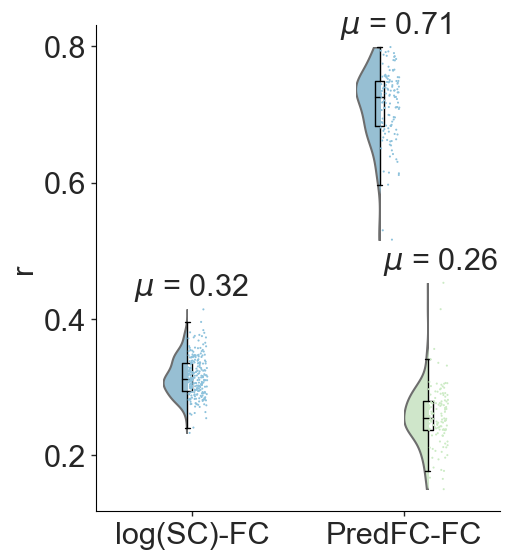

In [11]:
df_ind_corr = {}

df_ind_corr['Mode'] = []
df_ind_corr['Correlation'] = []
df_ind_corr['Type'] = []


for i in range(len(corr_SC_FC)):
    df_ind_corr['Correlation'].append(corr_SC_FC[i])
    df_ind_corr['Mode'].append('Actual')
    df_ind_corr['Type'].append('log(SC)-FC')

for i in range(len(corr_predFC_FC)):
    df_ind_corr['Correlation'].append(corr_predFC_FC[i])
    df_ind_corr['Mode'].append('Actual')
    df_ind_corr['Type'].append('PredFC-FC')

    df_ind_corr['Correlation'].append(corr_predFC_FC_re[i])
    df_ind_corr['Mode'].append('Rewire SC')
    df_ind_corr['Type'].append('PredFC-FC')

df_ind_corr = pd.DataFrame(df_ind_corr)

plt.rcParams['font.family'] = 'Arial'
fig, _= plt.subplots(figsize=(5.5,6))

ax = sns.violinplot(x="Type",y="Correlation",hue="Mode", data=df_ind_corr, dodge=True,
                    palette=sns_colors, width=0.5, cut=0,
                    scale="width", inner=None)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xticks = ax.get_xticks()

x_index = []
for violin in ax.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width / 2, height, transform=ax.transData))
    x_index.append(x0+ width / 2)
old_len_collections = len(ax.collections)
plt.boxplot([corr_SC_FC, corr_predFC_FC, corr_predFC_FC_re], positions=x_index, widths=0.05, showfliers=False, medianprops=dict(color='black'))

sns.stripplot(x="Type", y="Correlation", data=df_ind_corr, hue="Mode", palette=sns_colors, dodge=True, ax=ax,size=1.5, jitter=True, alpha=1)

#
for (ind, dots) in enumerate(ax.collections[old_len_collections:]):
    if ind!=1 and ind!=3 and ind!=4:
        dots.set_offsets(dots.get_offsets() + np.array([0.13, 0]))
    else:
        dots.set_offsets(dots.get_offsets() + np.array([-.02, 0]))


ax.legend_.remove()
plt.xticks(fontsize=22, rotation=0)
plt.xlabel(None)
plt.ylabel('r',fontsize=22)
plt.yticks(rotation=0, fontsize=22)
plt.annotate(r'$\mu$'+ ' = ' + str(round(mean_r_SC,2)),xy=(-0.4,np.max(corr_SC_FC)+0.02), fontsize=22,xycoords='data')
plt.annotate(r'$\mu$'+ ' = ' + str(round(mean_r_predFC,2)),xy=(0.67,np.max(corr_predFC_FC)+0.02), fontsize=22,xycoords='data')
plt.annotate(r'$\mu$'+ ' = ' + str(round(mean_r_predFC_re,2)),xy=(0.89,np.max(corr_predFC_FC_re)+0.02), fontsize=22,xycoords='data')
# plt.ylim([0,0.8])
xticks[0] = xticks[0]
ax.set_xticks([-0.1, 1])
ax.set_xticklabels(['log(SC)-FC','PredFC-FC' ])
plt.yticks(np.arange(0.2, 0.81, 0.2))
ax.set_xlim((-0.6, 1.5))
# ax.set_ylim(ylim)
plt.tight_layout()
plt.grid(False)
ax.tick_params(bottom=True, left=True, width=1)

sns.despine()
plt.savefig("../result_plot/Fig2/" + dataset_type + '_ind_overall.png', dpi=360, transparent=True)
plt.show()